In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool

import time
import warnings
from tqdm.notebook import tqdm

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin




In [2]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [3]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)

HalfBath_coeff = 0.5
BsmtFullBath_coeff = 1
BsmtHalfBath_coeff = 0.5
                         

X_fe['TotalBaths'] = (X_fe['FullBath'] + 
                      HalfBath_coeff * X_fe['HalfBath'] + 
                      BsmtFullBath_coeff * X_fe['BsmtFullBath'] + 
                      BsmtHalfBath_coeff * X_fe['BsmtHalfBath'])


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual']

X_fe = X_fe.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [253]:
# def _patch_ct(ct: ColumnTransformer):
#     try:
#         params = ct.get_params(deep=False)
#         if "force_int_remainder_cols" in params:
#             val = params["force_int_remainder_cols"]
#             if val == "deprecated" or not isinstance(val, (bool,)):
#                 ct.set_params(force_int_remainder_cols=False)
#     except Exception:
#         if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
#             del ct.__dict__["force_int_remainder_cols"]

# def patch_sklearn_objects(obj):
#     if isinstance(obj, ColumnTransformer):
#         _patch_ct(obj)
#         for _, trans, _ in getattr(obj, "transformers", []):
#             if isinstance(trans, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(trans)
#         return obj

#     if isinstance(obj, Pipeline):
#         for _, step in obj.steps:
#             if isinstance(step, (Pipeline, ColumnTransformer)):
#                 patch_sklearn_objects(step)
#         return obj

#     for attr in ("named_steps", "_final_estimator"):
#         if hasattr(obj, attr):
#             sub = getattr(obj, attr)
#             try:
#                 patch_sklearn_objects(sub)
#             except Exception:
#                 pass
#     return obj

In [4]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [6]:
pd.set_option('future.no_silent_downcasting', True)

import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import KFold, ParameterSampler, cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.base import clone
from catboost import CatBoostRegressor
import time, math, warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1) Small helpers ---

def neg_rmse_scorer():
    # scikit-learn has "neg_root_mean_squared_error" but we'll make it explicit
    def rmse(y_true, y_pred):
        return float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return make_scorer(rmse, greater_is_better=False)

def build_ttr_from_params(X_schema: pd.DataFrame, **cb_params):
    """
    Build your preprocessing+CatBoost pipeline, then wrap in TTR so CV is log1p→expm1.
    Using your make_catboost_pipe avoids the 'RL' casting error.
    """
    pipe = make_catboost_pipe(X_schema, **cb_params)  # <-- YOUR function
    ttr = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False,
    )
    return ttr

# --- 2) Tuner with lightweight progress ---

def tune_catboost_with_progress(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_iter: int = 60,
    folds: int = 5,
    random_state: int = 42,
    base_params: dict | None = None,
    search_space: dict | None = None,
    show_every: int = 1,   # print every iteration
):
    """
    Random-sample hyperparams; K-fold CV each; print compact progress lines.
    Returns (best_params, best_cv_rmse, final_model_fit_on_all_data).
    """
    rng = np.random.RandomState(random_state)

    # sensible default space (narrow enough to be efficient; broad enough to explore)
    default_space = {
        "depth":               [4,5,6,7],
        "iterations":          [2000, 3000, 4500, 6000, 7500],
        "learning_rate":       np.logspace(np.log10(0.012), np.log10(0.08), 15),
        "l2_leaf_reg":         np.logspace(np.log10(1.0), np.log10(10.0), 10),
        "subsample":           np.linspace(0.65, 1.0, 8),
        "colsample_bylevel":   np.linspace(0.45, 1.0, 8),
        "bagging_temperature": np.linspace(0.0, 3.0, 10),
        "random_strength":     np.linspace(0.0, 2.0, 10),
        "min_data_in_leaf":    [60, 90, 120, 150, 180, 220, 260, 300],
    }
    space = search_space or default_space

    # base params (fixed) — you can seed with something you liked before
    fixed = dict(
        loss_function="RMSE",
        random_state=random_state,
        verbose=0,
        thread_count=-1,   # keep n_jobs=1 in CV to avoid oversubscription
    )
    if base_params:
        fixed.update(base_params)

    sampler = ParameterSampler(space, n_iter=n_iter, random_state=random_state)

    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    scorer = neg_rmse_scorer()

    best_rmse = np.inf
    best_params = None
    history = []

    print(f"Fitting {folds} folds for each of {n_iter} candidates → total {n_iter*folds} fits")
    start = time.time()

    for i, sampled in enumerate(sampler, start=1):
        params = deepcopy(fixed)
        params.update(sampled)

        # build TTR( make_catboost_pipe(...) ) each time so CatBoost sees only numeric arrays
        model = build_ttr_from_params(X, **params)

        # cross-validated RMSE in *dollars* (thanks to TTR inverse)
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer, n_jobs=1)
        rmse_dollars = -np.mean(scores)

        history.append((i, rmse_dollars, params))
        if rmse_dollars < best_rmse:
            best_rmse = rmse_dollars
            best_params = deepcopy(params)

        if (i % show_every) == 0:
            elapsed = time.time() - start
            print(f"[{i:>3}/{n_iter}] CV RMSE = {rmse_dollars:,.0f}  |  best = {best_rmse:,.0f}  |  {elapsed:,.0f}s")

    # Fit final model on all data with the best params
    final_model = build_ttr_from_params(X, **best_params).fit(X, y)

    print("\nDone.")
    print(f"Best CV RMSE: {best_rmse:,.0f}")
    print("Best params:", {k: best_params[k] for k in sorted(best_params)})

    return best_params, best_rmse, final_model, history

# --- 3) Example call (runs now) ---

# (Optional) seed with a set you liked previously
seed_params = dict(
    depth=5,
    iterations=3525,
    learning_rate=0.04646200613219409,
    l2_leaf_reg=2.79206264384178,
    subsample=0.7737417681056152,
    colsample_bylevel=0.8591483762431275,
    bagging_temperature=2.7192215619579607,
    random_strength=1.9079506260866257,
    min_data_in_leaf=185,
)

best_params, best_cv_rmse, cb_final_ttr, search_log = tune_catboost_with_progress(
    X_fe, y,
    n_iter=80,          # bump this as high as you want
    folds=5,
    random_state=42,
    base_params=None,  # you can set None if you don’t want a seed
    show_every=1
)

# You can now use cb_final_ttr.predict(X_fe) safely (no 'RL' error),
# and the predictions are in *dollars* because of TTR inverse_func.

Fitting 5 folds for each of 80 candidates → total 400 fits
[  1/80] CV RMSE = 20,066  |  best = 20,066  |  26s
[  2/80] CV RMSE = 19,610  |  best = 19,610  |  60s
[  3/80] CV RMSE = 19,963  |  best = 19,610  |  98s
[  4/80] CV RMSE = 19,226  |  best = 19,226  |  125s
[  5/80] CV RMSE = 19,687  |  best = 19,226  |  166s
[  6/80] CV RMSE = 19,256  |  best = 19,226  |  188s
[  7/80] CV RMSE = 19,617  |  best = 19,226  |  245s
[  8/80] CV RMSE = 19,212  |  best = 19,212  |  287s
[  9/80] CV RMSE = 19,668  |  best = 19,212  |  389s
[ 10/80] CV RMSE = 20,358  |  best = 19,212  |  398s
[ 11/80] CV RMSE = 19,549  |  best = 19,212  |  483s
[ 12/80] CV RMSE = 20,114  |  best = 19,212  |  493s
[ 13/80] CV RMSE = 19,849  |  best = 19,212  |  541s
[ 14/80] CV RMSE = 19,500  |  best = 19,212  |  571s
[ 15/80] CV RMSE = 19,645  |  best = 19,212  |  615s
[ 16/80] CV RMSE = 20,028  |  best = 19,212  |  646s
[ 17/80] CV RMSE = 19,842  |  best = 19,212  |  678s
[ 18/80] CV RMSE = 19,332  |  best = 19,212

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,CatBoost (tuned),19507.705952,3532.260914,0.930159,0.997782


Full-fit RMSE: $3,533  |  R²: 0.998
count     2580.000000
mean       155.220797
std       3530.376304
min     -16882.550388
25%      -1823.209186
50%         93.658761
75%       2023.994267
max      19020.323335


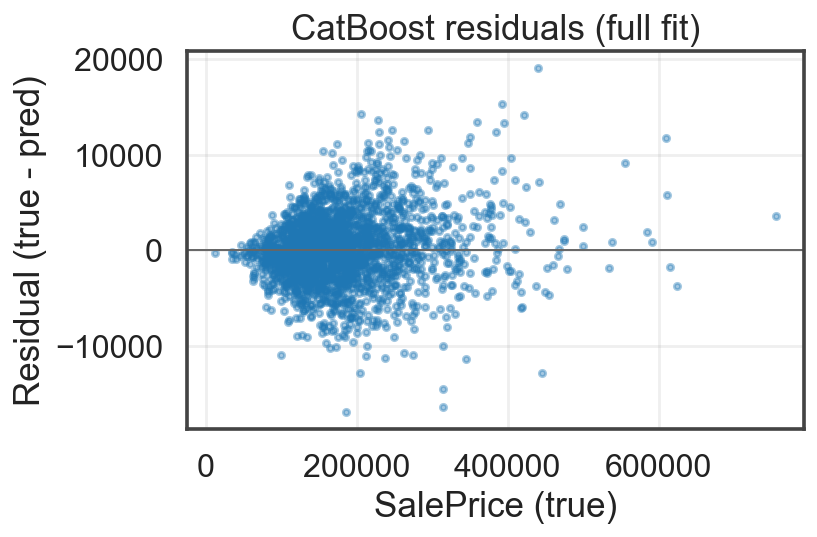

In [221]:
pd.set_option('future.no_silent_downcasting', True)
# --- 0) Your tuned CatBoost params
cb_best = best_params

# --- 1) Build pipeline (tree-friendly preprocessing + CatBoost)
cb_pipe = make_catboost_pipe(X_fe, **cb_best)

# --- 2) 5-fold CV on log-price; report RMSE ($), R² (OOF + full)
results = cv_eval_models(
    X=X_fe,
    y=y,
    models=[("CatBoost (tuned)", cb_pipe)],
    cv=5,
    random_state=42,
    log_target=True,       # log1p during fit, expm1 on predict
    show_progress=False
)
display(results)

# --- 3) Fit once on all data for final diagnostics
cb_pipe.fit(X_fe, np.log1p(y))
y_hat = np.expm1(cb_pipe.predict(X_fe))

# Metrics on full fit (for reference only—use CV for honesty)
from sklearn.metrics import r2_score, mean_squared_error
rmse_full = np.sqrt(mean_squared_error(y, y_hat))
r2_full   = r2_score(y, y_hat)
print(f"Full-fit RMSE: ${rmse_full:,.0f}  |  R²: {r2_full:.3f}")

# --- 4) Quick diagnostic table (OOF-style approximation via CV helper)
# If you want true OOF preds, re-run cv loop to capture them; here we just inspect residuals on full fit.
import pandas as pd
diag = pd.DataFrame({
    "y_true": y,
    "y_pred": y_hat,
    "residual": y - y_hat
})
print(diag.residual.describe().to_string())

# --- 5) Tiny residual plot to eyeball bias
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4), dpi=140)
plt.scatter(y, diag["residual"], s=10, alpha=0.4)
plt.axhline(0, color="#666", lw=1)
plt.xlabel("SalePrice (true)")
plt.ylabel("Residual (true - pred)")
plt.title("CatBoost residuals (full fit)")
plt.tight_layout()
plt.show()

In [222]:

cb_pipe = make_catboost_pipe(X_fe, **cb_best)

In [223]:


def get_oof_predictions(pipe, X, y, cv=5, random_state=42, log_target=True):
    """Return OOF predictions (in dollars), fold-by-fold metrics, and trained fold models."""
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y, dtype=float)

    oof_pred = np.zeros(len(y_np), dtype=float)
    fold_models = []
    fold_metrics = []

    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y_np[tr_idx], y_np[va_idx]

        y_tr_fit = np.log1p(y_tr) if log_target else y_tr
        pipe_fold = make_catboost_pipe(X, **best_cb_params)  # fresh model each fold
        pipe_fold.fit(X_tr, y_tr_fit)

        pred = pipe_fold.predict(X_va)
        pred = np.expm1(pred) if log_target else pred  # back to dollars
        oof_pred[va_idx] = pred

        rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
        r2   = float(r2_score(y_va, pred))
        fold_metrics.append({"rmse": rmse, "r2": r2})
        fold_models.append(pipe_fold)

    cv_rmse = float(np.mean([m["rmse"] for m in fold_metrics]))
    cv_r2   = float(np.mean([m["r2"]   for m in fold_metrics]))

    return oof_pred, fold_models, {"cv_rmse": cv_rmse, "cv_r2": cv_r2, "per_fold": fold_metrics}

# ---- run it
oof_pred, fold_models, cv_stats = get_oof_predictions(cb_pipe, X_fe, y, cv=5, random_state=42, log_target=True)

print(f"CV RMSE (OOF): {cv_stats['cv_rmse']:,.0f}")
print(f"CV R²   (OOF): {cv_stats['cv_r2']:.3f}")

CV RMSE (OOF): 19,601
CV R²   (OOF): 0.930


In [224]:
df_oof = X_fe.copy()
df_oof["_idx"]     = np.arange(len(df_oof), dtype=int)
df_oof["_id_"]     = df_oof.index              # or a stable id column if you have one
df_oof["y_true"]   = y.astype(float).to_numpy()
df_oof["oof_pred"] = oof_pred.astype(float)
df_oof["oof_resid"] = df_oof["y_true"] - df_oof["oof_pred"]  # <-- true OOF residuals

# For your later “underpriced pick” logic, create a compact base table:
candidates_base = df_oof.rename(columns={
    "oof_pred": "base_pred",
    "oof_resid": "residual"
})[["_idx","_id_","y_true","base_pred","residual"]]

candidates_base.head()

,_idx,_id_,y_true,base_pred,residual
1,0,1,126000.0,119591.452119,6408.547881
2,1,2,139500.0,130490.645842,9009.354158
3,2,3,124900.0,105882.654921,19017.345079
4,3,4,114000.0,104266.552271,9733.447729
5,4,5,227000.0,213783.456810,13216.543190


In [225]:
cb_final = make_catboost_pipe(X_fe, **cb_best)
cb_final.fit(X_fe, np.log1p(y))  # keep the same log-target convention

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


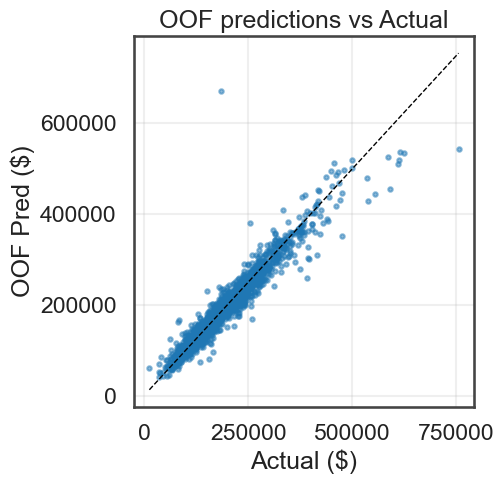

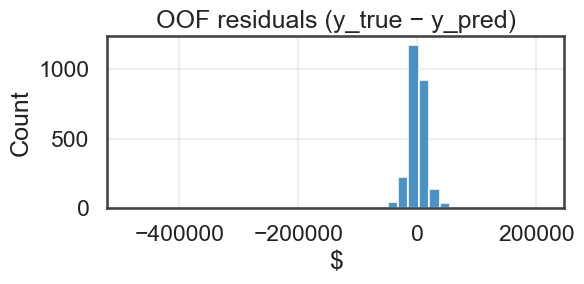

In [226]:
plt.figure(figsize=(5,5))
plt.scatter(df_oof["y_true"], df_oof["oof_pred"], s=10, alpha=0.5)
lims = [min(df_oof["y_true"].min(), df_oof["oof_pred"].min()),
        max(df_oof["y_true"].max(), df_oof["oof_pred"].max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("Actual ($)"); plt.ylabel("OOF Pred ($)"); plt.title("OOF predictions vs Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.hist(df_oof["oof_resid"], bins=40, alpha=0.8)
plt.title("OOF residuals (y_true − y_pred)"); plt.xlabel("$"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

In [227]:
# --- 1) Train/val split ---


X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

# --- 2) Tell CatBoost which columns are categorical ---
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]  # indices CatBoost expects

# (optional but safe) force cats to string dtype
for c in cat_cols:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

# --- 3) Fit CatBoost with your best param set (swap if you choose another) ---
# cb_params = dict(
#     depth=5,
#     iterations=3525,
#     learning_rate=0.04646200613219409,
#     l2_leaf_reg=2.79206264384178,
#     subsample=0.7737417681056152,
#     colsample_bylevel=0.8591483762431275,
#     bagging_temperature=2.7192215619579607,
#     random_strength=1.9079506260866257,
#     min_data_in_leaf=185,
#     loss_function="RMSE",
#     random_state=42,
#     verbose=0
# )

cb_final = CatBoostRegressor(**cb_best)
cb_final.fit(X_train, y_train, cat_features=cat_idx)

# --- 4) Predict + metrics ---
y_pred_test  = cb_final.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test   = r2_score(y_test, y_pred_test)
print(f"Test RMSE: {rmse_test:,.0f}  |  R²: {r2_test:.3f}")

Test RMSE: 18,641  |  R²: 0.944


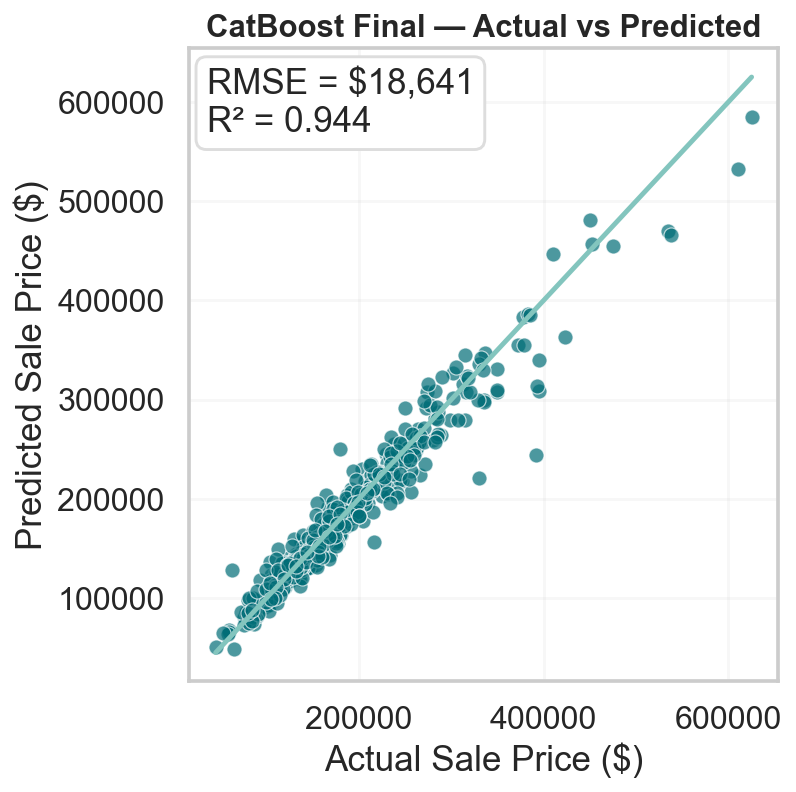

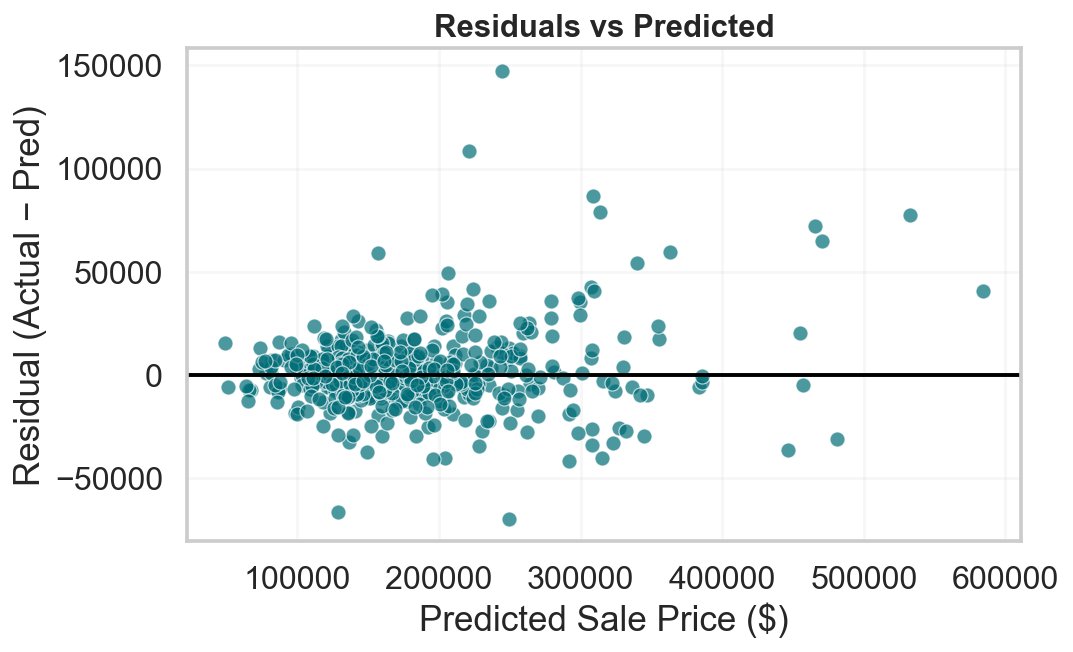

In [228]:
# Warwick colors
warwick_teal   = "#006d77"
warwick_accent = "#83c5be"

sns.set_style("whitegrid")
sns.set_context("talk")

# 1) Parity (Actual vs Predicted)
plt.figure(figsize=(6,6), dpi=140)
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, color=warwick_accent, lw=2.5)
plt.title("CatBoost Final — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
# annotate metrics
plt.text(0.03, 0.97, f"RMSE = ${rmse_test:,.0f}\nR² = {r2_test:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(facecolor="white", edgecolor="#ddd", boxstyle="round,pad=0.3"))
plt.tight_layout()
plt.show()

# 2) Residuals vs Predicted
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5), dpi=140)
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.7,
            edgecolor="white", linewidth=0.6, s=60)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)")
plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout()
plt.show()

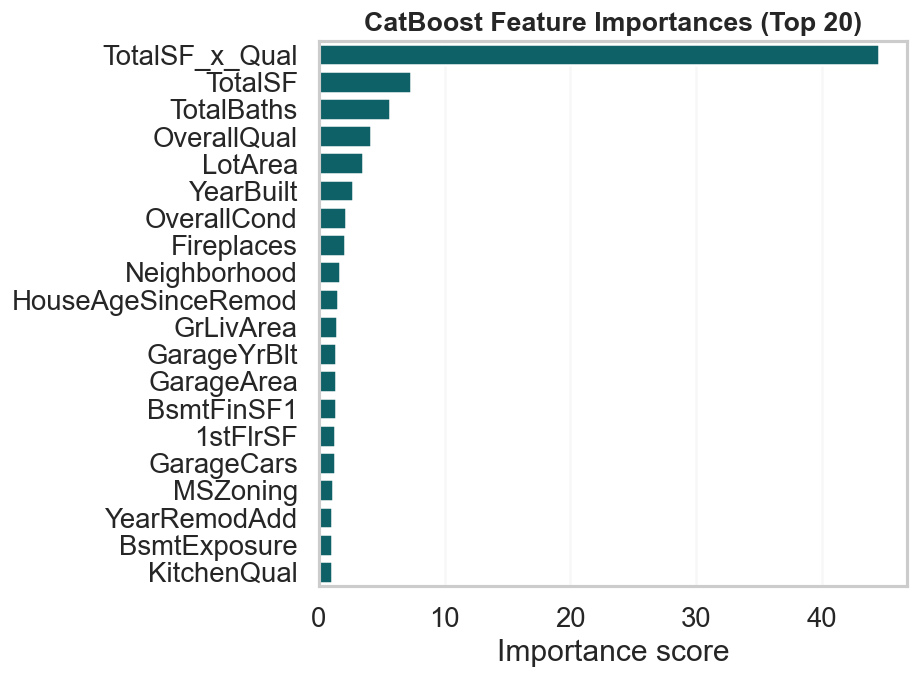

,Feature,Importance
82,TotalSF_x_Qual,44.521719
79,TotalSF,7.354573
81,TotalBaths,5.665846
17,OverallQual,4.141939
4,LotArea,3.519841
19,YearBuilt,2.732442
18,OverallCond,2.187758
55,Fireplaces,2.121799
12,Neighborhood,1.726242
80,HouseAgeSinceRemod,1.547381


In [229]:


# --- identify categorical columns ---
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# (optional) ensure NaNs are handled for cats; CatBoost can handle NaN, but many folks prefer explicit "None"
X_train_cat = X_train.copy()
X_test_cat  = X_test.copy()
for c in cat_cols:
    X_train_cat[c] = X_train_cat[c].astype("object")
    X_test_cat[c]  = X_test_cat[c].astype("object")

# --- final params (your chosen set) ---
# cb_params = dict(
#     depth=5,
#     iterations=3525,
#     learning_rate=0.04646200613219409,
#     l2_leaf_reg=2.79206264384178,
#     subsample=0.7737417681056152,
#     colsample_bylevel=0.8591483762431275,
#     bagging_temperature=2.7192215619579607,
#     random_strength=1.9079506260866257,
#     min_data_in_leaf=185,
#     loss_function="RMSE",
#     random_state=42,
#     verbose=0
# )

# --- fit with cat_features specified ---
cb_final = CatBoostRegressor(**cb_best)
cb_final.fit(
    X_train_cat, y_train,
    cat_features=cat_cols,
    eval_set=Pool(X_test_cat, y_test, cat_features=cat_cols),
    use_best_model=True
)

# --- feature importances (plain score) ---
train_pool = Pool(X_train_cat, y_train, cat_features=cat_cols)
imp = cb_final.get_feature_importance(train_pool, type="FeatureImportance")
feat_imp = (
    pd.DataFrame({"Feature": X_train_cat.columns, "Importance": imp})
      .sort_values("Importance", ascending=False)
)

# --- plot top 20 in your palette ---
sns.set_style("whitegrid"); sns.set_context("talk")
TEAL = "#006d77"

plt.figure(figsize=(8, 6), dpi=120)
topk = 20
ax = sns.barplot(
    data=feat_imp.head(topk),
    y="Feature", x="Importance", color=TEAL
)
ax.set_title("CatBoost Feature Importances (Top 20)", fontsize=16, weight="bold")
ax.set_xlabel("Importance score"); ax.set_ylabel("")
plt.tight_layout(); plt.show()

feat_imp.head(20)

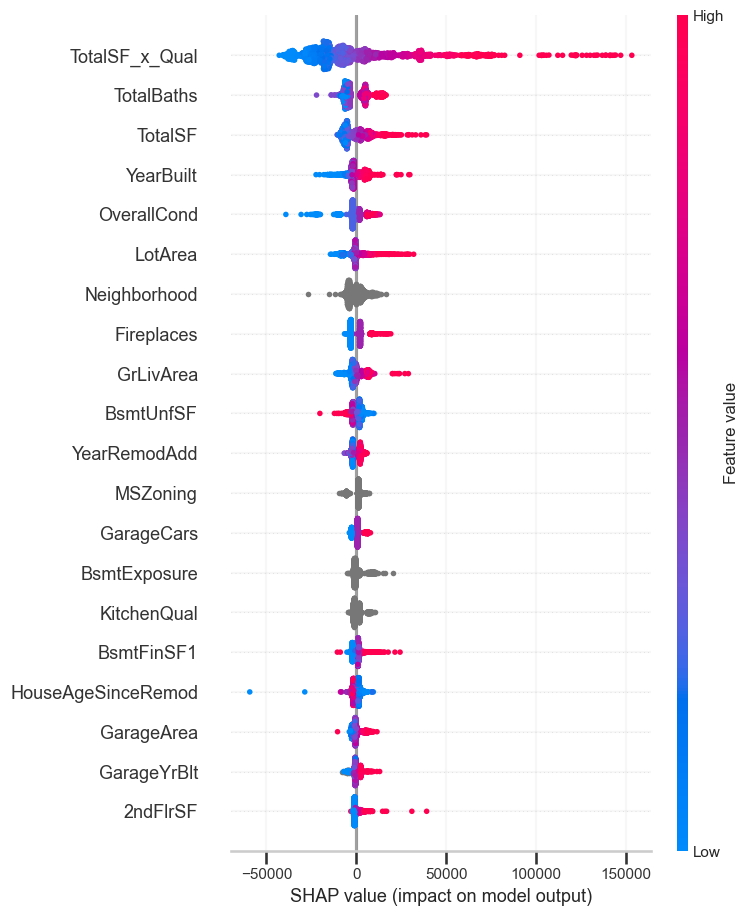

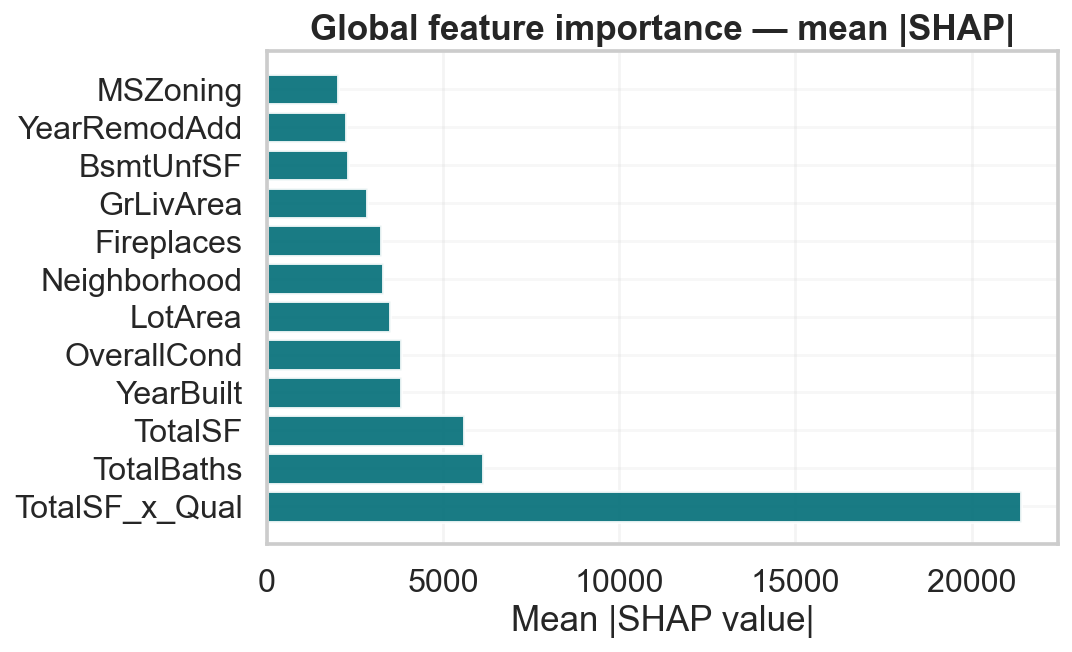

In [230]:
# --- 0) Theme colors for plots ---
warwick_teal   = "#006d77"
warwick_accent = "#83c5be"

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import shap

# --- 1) Prep Pools (fix NaNs in categoricals) ---
def make_cat_pools(X_tr: pd.DataFrame, y_tr, X_te: pd.DataFrame, y_te):
    X_tr = X_tr.copy()
    X_te = X_te.copy()

    # find categorical columns
    cat_cols = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()

    # CatBoost requires strings (no NaN) for categoricals
    for c in cat_cols:
        X_tr[c] = X_tr[c].astype("object").fillna("None").astype(str)
        X_te[c] = X_te[c].astype("object").fillna("None").astype(str)

    # Optional: ensure numerics have no inf
    num_cols = X_tr.columns.difference(cat_cols)
    for c in num_cols:
        X_tr[c] = pd.to_numeric(X_tr[c], errors="coerce")
        X_te[c] = pd.to_numeric(X_te[c], errors="coerce")

    # CatBoost accepts names or indices for cat_features
    train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
    test_pool  = Pool(X_te, y_te, cat_features=cat_cols)
    return train_pool, test_pool, X_tr, X_te, cat_cols

train_pool, test_pool, Xtr_fixed, Xte_fixed, cat_cols = make_cat_pools(X_train, y_train, X_test, y_test)

# --- 2) Fit your chosen parameter set (Set 1 from your leaderboard) ---
# cb_params = dict(
#     depth=5,
#     iterations=3525,
#     learning_rate=0.04646200613219409,
#     l2_leaf_reg=2.79206264384178,
#     subsample=0.7737417681056152,
#     colsample_bylevel=0.8591483762431275,
#     bagging_temperature=2.7192215619579607,
#     random_strength=1.9079506260866257,
#     min_data_in_leaf=185,
#     loss_function="RMSE",
#     random_state=42,
#     verbose=0
# )

cb_final = CatBoostRegressor(**cb_best)
cb_final.fit(train_pool, eval_set=test_pool, use_best_model=True)

# --- 3) SHAP values (CatBoost-native) ---
# Returns array [n_samples, n_features + 1]; last column = expected_value (base)
shap_vals = cb_final.get_feature_importance(train_pool, type="ShapValues")
shap_values = shap_vals[:, :-1]
expected_value = shap_vals[:, -1]

# Make sure feature order matches columns
feature_names = list(Xtr_fixed.columns)

# --- 3a) Beeswarm summary (global direction + spread) ---
shap.summary_plot(
    shap_values, Xtr_fixed, feature_names=feature_names,
    show=True, color=warwick_teal
)

# --- 3b) Top-k mean |SHAP| bar (nice for slides) ---
mean_abs_shap = np.abs(shap_values).mean(axis=0)
order = np.argsort(mean_abs_shap)[::-1]
top_k = 12  # adjust for slide
top_feats = [feature_names[i] for i in order[:top_k]]
top_vals  = mean_abs_shap[order[:top_k]]

plt.figure(figsize=(8, 5), dpi=140)
plt.barh(range(top_k), top_vals[::-1], color=warwick_teal, alpha=0.9)
plt.yticks(range(top_k), top_feats[::-1])
plt.gca().invert_yaxis()
plt.title("Global feature importance — mean |SHAP|", weight="bold")
plt.xlabel("Mean |SHAP value|")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

In [231]:
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.base import clone
from catboost import CatBoostRegressor, Pool

# --- your ORDINAL_ORDER, step_ordinal_series, to_best_series, UPGRADES stay as-is ---

def prep_for_catboost(X: pd.DataFrame) -> tuple[pd.DataFrame, list[int]]:
    """Make categoricals safe for CatBoost and return their column indices."""
    Xc = X.copy()
    cat_cols = Xc.select_dtypes(include=["object","category","bool"]).columns.tolist()
    for c in cat_cols:
        Xc[c] = Xc[c].astype("object").fillna("NA").astype(str)
    return Xc, [Xc.columns.get_loc(c) for c in cat_cols]

def _auto_to_dollars(raw_pred: np.ndarray) -> np.ndarray:
    """If predictions look like log-space, expm1 them; else return as-is."""
    raw_pred = raw_pred.astype(float)
    return np.expm1(raw_pred) if np.nanmedian(raw_pred) < 1000 else raw_pred

def get_oof_base_df(
    estimator: CatBoostRegressor,
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_splits: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """True OOF residuals for every row (no debiasing)."""
    Xc, cat_idx = prep_for_catboost(X)
    y_true = y.astype(float).to_numpy()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    base_pred = np.zeros(len(Xc), dtype=float)

    for tr, va in kf.split(Xc):
        est = clone(estimator)
        train_pool = Pool(Xc.iloc[tr], np.log1p(y_true[tr]), cat_features=cat_idx)
        valid_pool = Pool(Xc.iloc[va],         cat_features=cat_idx)
        est.fit(train_pool, verbose=False)
        base_pred[va] = _auto_to_dollars(est.predict(valid_pool))

    df = pd.DataFrame({
        "_idx":      np.arange(len(Xc), dtype=int),
        "_id_":      np.arange(1, len(Xc)+1, dtype=int),  # or your real id if you have it
        "y_true":    y_true,
        "base_pred": base_pred,
    })
    df["residual"] = df["y_true"] - df["base_pred"]
    return df

def predict_dollars_auto(model: CatBoostRegressor, X: pd.DataFrame) -> np.ndarray:
    Xc, cat_idx = prep_for_catboost(X)
    pool = Pool(Xc, cat_features=cat_idx)
    return _auto_to_dollars(model.predict(pool))

In [232]:
# pick your winning params (you said "set 1" was best)
X_cb, cat_idx = prep_for_catboost(X_fe)
cb_final = CatBoostRegressor(**cb_best)
cb_final.fit(Pool(X_cb, np.log1p(y), cat_features=cat_idx), verbose=False)

In [233]:
base_df_oof = get_oof_base_df(CatBoostRegressor(**cb_params), X_fe, y, n_splits=5, random_state=42)
print("base_df_oof shape:", base_df_oof.shape)
print(base_df_oof.head())

base_df_oof shape: (2580, 5)
   _idx  _id_    y_true      base_pred      residual
0     0     1  126000.0  134862.338680  -8862.338680
1     1     2  139500.0  136851.912965   2648.087035
2     2     3  124900.0  118106.316616   6793.683384
3     3     4  114000.0  104982.386485   9017.613515
4     4     5  227000.0  213849.093332  13150.906668


In [234]:
# --- Upgrades list (your list) ---
UPGRADES = [
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

# --- small helpers for categorical steps ---
def step_ordinal_series(s: pd.Series, order: list[str], step: int) -> pd.Series:
    cat = pd.Categorical(s, categories=order, ordered=True)
    codes = cat.codes
    valid = codes >= 0
    new_codes = codes.copy()
    new_codes[valid] = np.clip(new_codes[valid] + step, 0, len(order)-1)
    out = pd.Series(pd.Categorical.from_codes(new_codes, categories=order, ordered=True), index=s.index)
    return out.astype(object)

def to_best_series(s: pd.Series, order: list[str]) -> pd.Series:
    top = order[-1]
    out = s.copy()
    out.loc[s.notna()] = top
    return out.astype(object)

# --- CatBoost-aware predictor ---
def predict_dollars_cb(cb_model: CatBoostRegressor, X: pd.DataFrame, *, target_log=True, cat_cols=None) -> np.ndarray:
    pool = Pool(X, cat_features=list(cat_cols or []))
    raw = cb_model.predict(pool)
    return np.expm1(raw) if target_log else raw

In [184]:
def simulate_upgrades_fast(
    cb_model,
    base_df: pd.DataFrame,
    X: pd.DataFrame,
    upgrades=UPGRADES,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    if "residual" not in base_df.columns:
        raise KeyError("base_df must contain 'residual' (use OOF base table).")

    # select top 30% underpriced (positive residuals)
    k = max(1, int(round(0.30 * len(base_df))))
    under = base_df.nlargest(k, "residual")[["_idx","_id_","base_pred","y_true","residual"]].copy()
    idxs = under["_idx"].to_numpy()
    X_slice = X.iloc[idxs].copy()

    combos = []
    for upg in upgrades:
        f = upg["feature"]
        if f not in X_slice.columns:
            continue
        X_mod = X_slice.copy()
        if "delta" in upg:
            X_mod[f] = pd.to_numeric(X_mod[f], errors="coerce").fillna(0.0) + upg["delta"]
        elif "step" in upg:
            order = ORDINAL_ORDER.get(f)
            if order is None:
                continue
            X_mod[f] = step_ordinal_series(X_mod[f], order, upg["step"])
        elif upg.get("to") == "best":
            order = ORDINAL_ORDER.get(f)
            if order is None:
                continue
            X_mod[f] = to_best_series(X_mod[f], order)
        else:
            continue
        combos.append((upg["upgrade"], f, X_mod))

    if not combos:
        out = under.copy()
        out["best_upgrade"] = np.nan; out["best_feature"] = np.nan
        out["best_new_pred"] = out["base_pred"]; out["best_uplift"] = 0.0
        return out, pd.DataFrame(columns=[])

    # bulk predict all variants
    big = pd.concat([df for _,_,df in combos], axis=0, ignore_index=False)
    rep_names    = np.concatenate([np.full(len(df), name, dtype=object) for name,_,df in combos])
    rep_features = np.concatenate([np.full(len(df), feat, dtype=object) for _,feat,df in combos])

    pred_all = predict_dollars_auto(cb_model, big)

    # long table aligned to 'under'
    repeated_keys = np.tile(under[["_idx","_id_","base_pred","y_true","residual"]].to_numpy(), (len(combos), 1))
    upgrades_long = pd.DataFrame({
        "_idx":       repeated_keys[:,0].astype(int),
        "_id_":       repeated_keys[:,1],
        "base_pred":  repeated_keys[:,2].astype(float),
        "y_true":     repeated_keys[:,3].astype(float),
        "residual":   repeated_keys[:,4].astype(float),
        "upgrade":    rep_names,
        "feature":    rep_features,
        "new_pred":   pred_all.astype(float)
    })
    upgrades_long["uplift"] = upgrades_long["new_pred"] - upgrades_long["base_pred"]

    best_per_home = (
        upgrades_long.sort_values(["_idx","uplift"], ascending=[True, False])
                     .groupby("_idx", as_index=False)
                     .first()
                     .drop(columns=["base_pred","y_true","residual"], errors="ignore")
                     .rename(columns={"upgrade":"best_upgrade","feature":"best_feature",
                                      "new_pred":"best_new_pred","uplift":"best_uplift"})
    )
    candidates_summary = under.merge(best_per_home, on="_idx", how="left") \
                              .sort_values(["residual","best_uplift"], ascending=[False, False], ignore_index=True)

    return candidates_summary, upgrades_long

# ---- Run it
candidates_summary, upgrades_long_ctx = simulate_upgrades_fast(
    cb_model=cb_final,
    base_df=base_df_oof,
    X=X_fe,
    upgrades=UPGRADES,
)

print("Candidates:", candidates_summary.shape, "Upgrades long:", upgrades_long_ctx.shape)

Candidates: (774, 10) Upgrades long: (9288, 9)


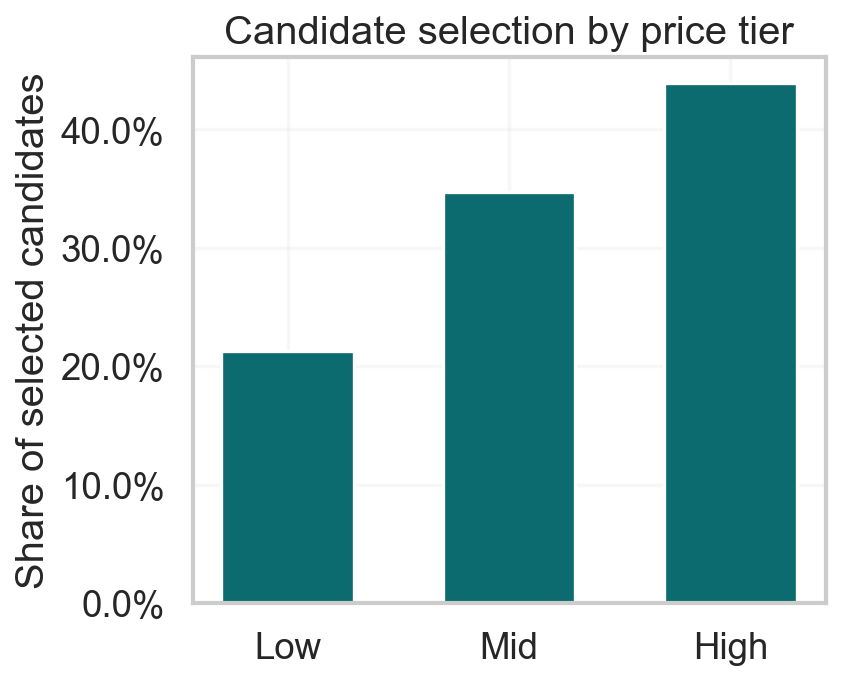

Selected share by tier:
  Low   21.3%
  Mid   34.8%
  High  43.9%


In [235]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# price tiers from ALL homes (terciles)
cuts = np.quantile(y_true, [0.33, 0.66])
bins_all = pd.Series(pd.cut(y_true, [-np.inf, *cuts, np.inf],
                            labels=["Low","Mid","High"],
                            ordered=True),
                     name="tier")

tiers = ["Low","Mid","High"]

# indices of selected (top-k OOF residuals you already have)
# top_idx_base = np.argsort(resid_base_oof)[-k:]

sel_tiers = bins_all.iloc[top_idx_base]
share = (sel_tiers.value_counts().reindex(tiers, fill_value=0) / len(sel_tiers))

fig, ax = plt.subplots(figsize=(5.6,4.6), dpi=160)
ax.bar(tiers, share.values, color="#0B6B6E", width=0.6)
ax.set_ylabel("Share of selected candidates")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title("Candidate selection by price tier")
plt.tight_layout(); plt.show()

print("Selected share by tier:")
for t, v in share.items():
    print(f"  {t:<4} {v:6.1%}")

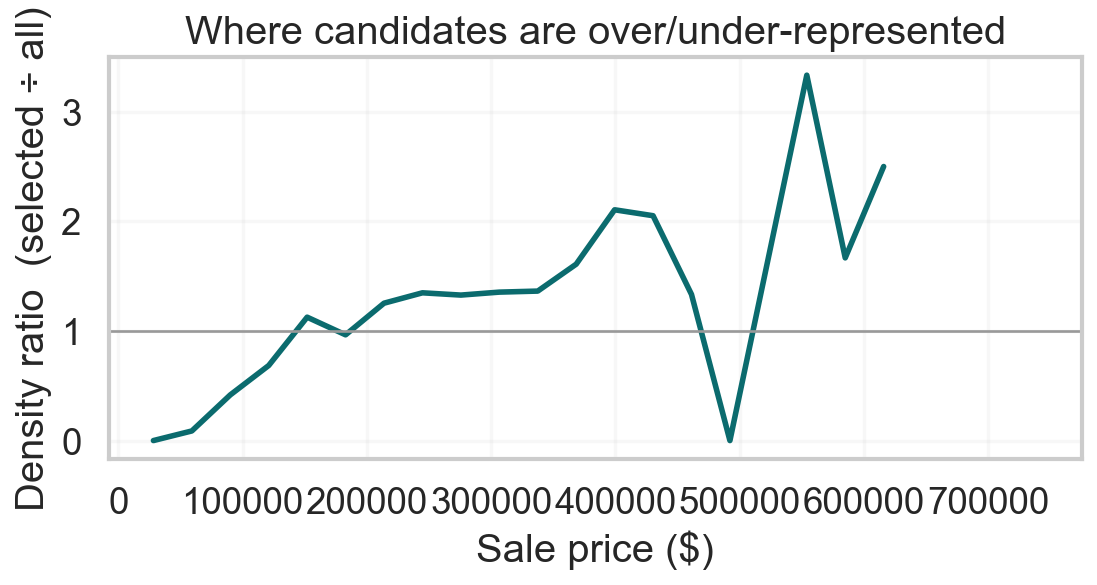

In [236]:
bins = np.linspace(y_true.min(), y_true.max(), 25)
h_all, _ = np.histogram(y_true, bins=bins, density=True)
h_sel, _ = np.histogram(y_true[top_idx_base], bins=bins, density=True)

ratio = np.divide(h_sel, h_all, out=np.full_like(h_all, np.nan), where=h_all>0)
centers = 0.5*(bins[1:]+bins[:-1])

fig, ax = plt.subplots(figsize=(7.2,4.0), dpi=160)
ax.plot(centers, ratio, lw=2.5, color="#0B6B6E")
ax.axhline(1.0, color="#999", lw=1.2)
ax.set_ylabel("Density ratio  (selected ÷ all)")
ax.set_xlabel("Sale price ($)")
ax.set_title("Where candidates are over/under-represented")
plt.tight_layout(); plt.show()

Overall selected rate: 30.000%
Size-weighted mean of decile shares: 30.000%


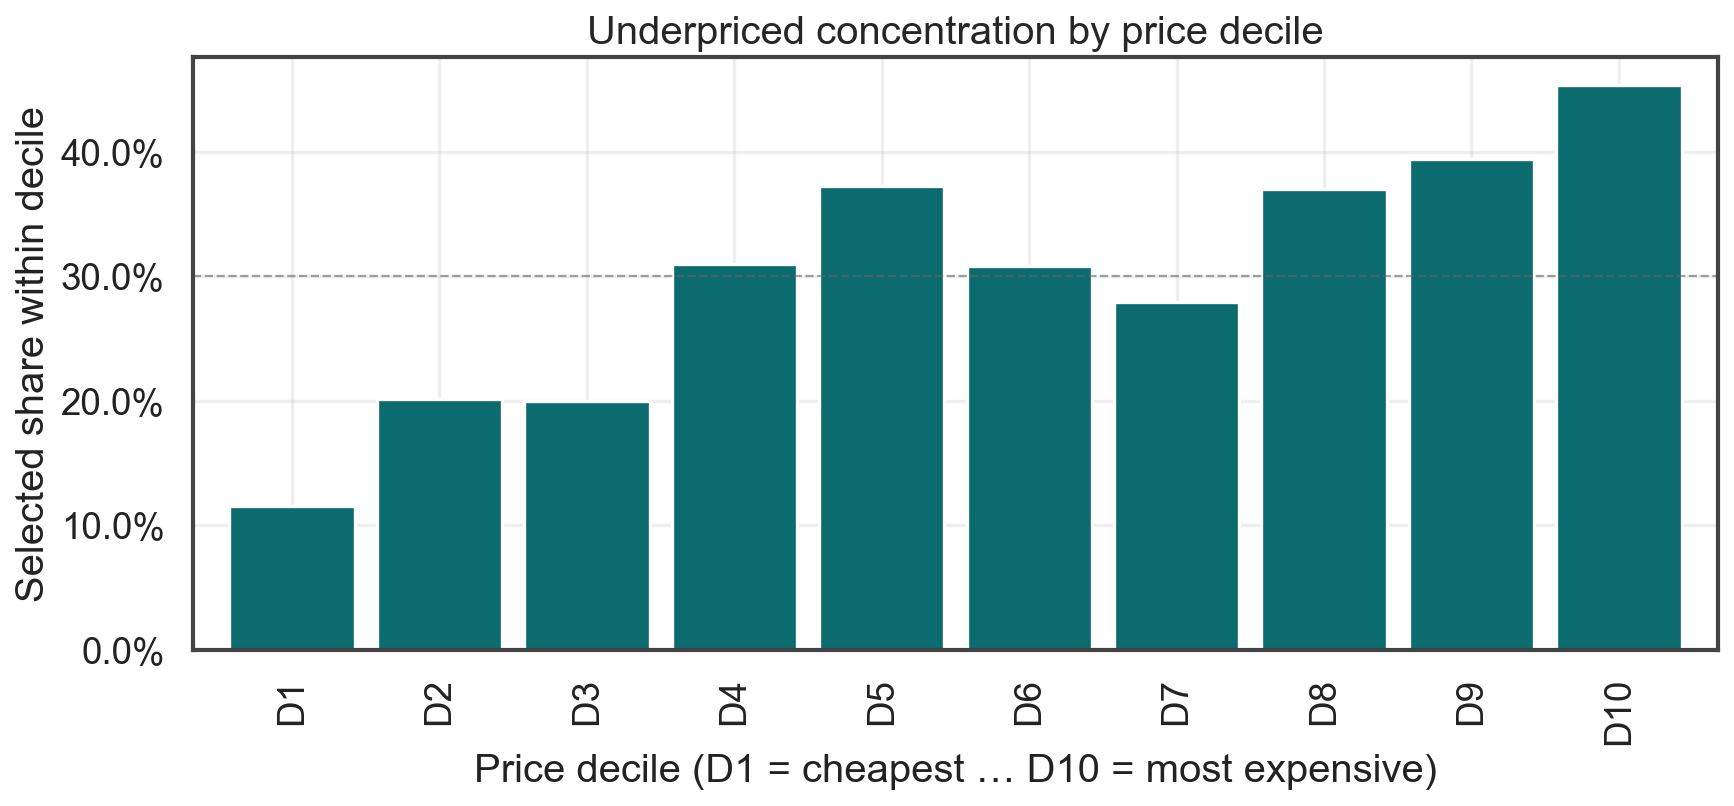

In [237]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

FIG_DPI = 160
warwick_teal = "#0B6B6E"

# --- Inputs you already have ---
# y_true: np.array of actual prices (len N)
# top_idx_base: indices of selected "underpriced" homes (size k ≈ 0.30*N)

# 1) Build price deciles over ALL homes
deciles = pd.qcut(y_true, 10, labels=[f"D{i}" for i in range(1, 11)])
deciles = pd.Series(deciles, index=np.arange(len(y_true)), name="decile")

# 2) Count totals per decile (denominator) and selected per decile (numerator)
totals = deciles.value_counts().sort_index()                       # all homes per decile
sel_deciles = deciles.loc[np.asarray(top_idx_base, int)]
selected = sel_deciles.value_counts().reindex(totals.index, fill_value=0)

# 3) Share within decile (this is what should hover ~30% on average)
share = (selected / totals).rename("share")

# Sanity: overall selected rate and size-weighted mean by decile
overall_rate = len(top_idx_base) / len(y_true)
weighted_mean = (share * (totals / totals.sum())).sum()
print(f"Overall selected rate: {overall_rate:.3%}")
print(f"Size-weighted mean of decile shares: {weighted_mean:.3%}")

# 4) Plot
plt.rcParams.update({
    "figure.facecolor":"white", "axes.facecolor":"white",
    "axes.grid":True, "grid.alpha":0.15, "grid.color":"#999999",
    "axes.edgecolor":"#444", "axes.labelcolor":"#222",
    "xtick.color":"#222", "ytick.color":"#222", "font.size":12
})

fig, ax = plt.subplots(figsize=(11,5.2), dpi=FIG_DPI)
share.plot(kind="bar", color=warwick_teal, ax=ax, width=0.85)

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Price decile (D1 = cheapest … D10 = most expensive)")
ax.set_ylabel("Selected share within decile")
ax.set_title("Underpriced concentration by price decile")

# Optional: faint 30% reference line
ax.axhline(overall_rate, color="#666", ls="--", lw=1, alpha=0.6)

fig.tight_layout()
fig.savefig("slide_candidates_by_decile.png", dpi=FIG_DPI)
plt.show()

Slope (residual ~ price): in-sample = -0.02675 | OOF = -0.002495  (closer to 0 is better)


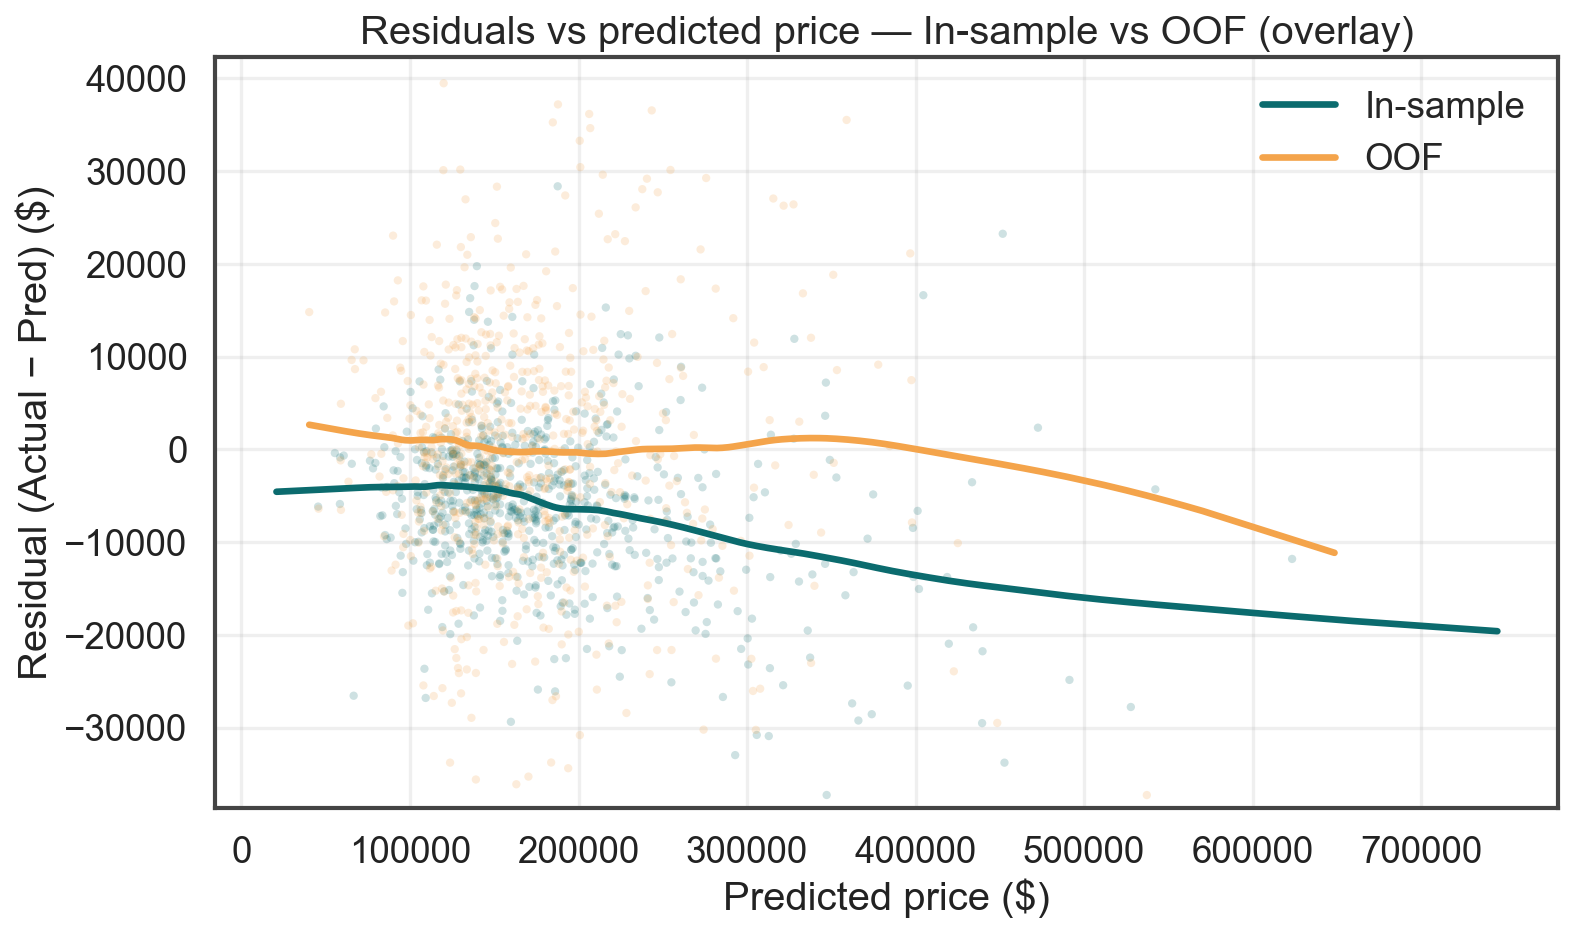

In [238]:
# --- Overlay: in-sample vs OOF residuals (robust to NaNs in categoricals) ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from catboost import Pool

# Colors
COL_IN  = "#0B6B6E"   # teal  — in-sample
COL_OOF = "#F4A44B"   # gold  — OOF

# 0) Identify categorical columns and make a CatBoost Pool helper
cat_cols = X_fe.select_dtypes(include=["object","category"]).columns.tolist()

def make_pool(df: pd.DataFrame, y=None) -> Pool:
    df2 = df.copy()
    if cat_cols:
        # CatBoost wants strings for categoricals (including missing)
        df2[cat_cols] = df2[cat_cols].astype("string").fillna("None")
    return Pool(df2, label=y, cat_features=cat_cols)

# 1) In-sample predictions from final model
y_true_full = y.to_numpy(float)
raw_pred_full = cb_final.predict(make_pool(X_fe)).astype(float)
y_pred_full  = np.expm1(raw_pred_full) if np.nanmedian(raw_pred_full) < 1_000 else raw_pred_full
resid_in     = y_true_full - y_pred_full

# 2) OOF residuals (already computed earlier)
y_true_oof = base_df_oof["y_true"].to_numpy(float)
y_pred_oof = base_df_oof["base_pred"].to_numpy(float)
resid_oof  = (base_df_oof["residual"].to_numpy(float)
              if "residual" in base_df_oof.columns else y_true_oof - y_pred_oof)

# 3) LOWESS helpers
def lowess_line(x, y, frac=0.30):
    m = np.isfinite(x) & np.isfinite(y)
    lo = lowess(y[m], x[m], frac=frac, it=1, return_sorted=True)
    return lo[:,0], lo[:,1]

x_in,  y_in  = lowess_line(y_pred_full, resid_in,  frac=0.30)
x_oof, y_oof = lowess_line(y_pred_oof,  resid_oof, frac=0.30)

# Optional: light subsample for cleaner clouds
def subsample(x, y, n=700, seed=7):
    if len(x) <= n: return x, y
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x), size=n, replace=False)
    return x[idx], y[idx]

xs_in,  rs_in  = subsample(y_pred_full, resid_in)
xs_oof, rs_oof = subsample(y_pred_oof,  resid_oof)

# 4) Plot
plt.rcParams.update({
    "figure.facecolor":"white","axes.facecolor":"white",
    "axes.grid":True,"grid.alpha":0.15,"grid.color":"#999999",
    "axes.edgecolor":"#444","axes.labelcolor":"#222",
    "xtick.color":"#222","ytick.color":"#222","font.size":12
})
fig, ax = plt.subplots(figsize=(10,6), dpi=160)

# scatter clouds
ax.scatter(xs_in,  rs_in,  s=14, alpha=0.20, color=COL_IN,  edgecolors="none")
ax.scatter(xs_oof, rs_oof, s=14, alpha=0.20, color=COL_OOF, edgecolors="none")

# trend lines
ax.plot(x_in,  y_in,  color=COL_IN,  lw=3, label="In-sample")
ax.plot(x_oof, y_oof, color=COL_OOF, lw=3, label="OOF")

# focus y-axis on central band of residuals
ymin, ymax = np.percentile(np.concatenate([resid_in, resid_oof]), [1, 99])
ax.set_ylim(ymin - 2500, ymax + 2500)

ax.set_xlabel("Predicted price ($)")
ax.set_ylabel("Residual (Actual − Pred) ($)")
ax.set_title("Residuals vs predicted price — In-sample vs OOF (overlay)")
ax.legend(frameon=False, loc="upper right")

# quick numeric cue for your notes
slope_in  = np.polyfit(y_pred_full, resid_in,  1)[0]
slope_oof = np.polyfit(y_pred_oof,  resid_oof, 1)[0]
print(f"Slope (residual ~ price): in-sample = {slope_in:.4g} | OOF = {slope_oof:.4g}  (closer to 0 is better)")

plt.tight_layout()
plt.show()

In [242]:
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

# --- 1) Keep object columns as strings for CatBoost (no NaN -> 'None') ---
def prepare_for_catboost(X: pd.DataFrame) -> tuple[pd.DataFrame, list]:
    Xp = X.copy()
    cat_cols = Xp.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols:
        Xp[cat_cols] = Xp[cat_cols].astype("string").fillna("None")
    return Xp, cat_cols

# --- 2) Safe interaction-maker (None -> 1.0, robust casting) ---
def make_X_variant(X: pd.DataFrame, power) -> pd.DataFrame:
    p = 1.0 if power is None else float(power)
    Xv = X.copy()

    # ensure numeric inputs for the interaction only (do NOT touch other dtypes)
    sf   = pd.to_numeric(Xv["TotalSF"], errors="coerce")
    qual = pd.to_numeric(Xv["OverallQual"], errors="coerce")

    # optional: light impute, keeps CatBoost happy if you prefer no NaNs here
    sf   = sf.fillna(sf.median())
    qual = qual.fillna(qual.median())

    Xv["TotalSF_x_Qual"] = sf * (qual ** p)
    return Xv

# --- 3) Quick OOF evaluator (log1p target as you’ve been using) ---
def oof_eval(X: pd.DataFrame, y: pd.Series, params: dict, n_splits=5, seed=42):
    Xp, cat_cols = prepare_for_catboost(X)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    oof = np.zeros(len(y), dtype=float)
    for tr, va in kf.split(Xp):
        train_pool = Pool(Xp.iloc[tr], np.log1p(y.iloc[tr]), cat_features=cat_cols)
        valid_pool = Pool(Xp.iloc[va],                     cat_features=cat_cols)
        model = CatBoostRegressor(**params)
        model.fit(train_pool, verbose=False)
        raw = model.predict(valid_pool).astype(float)
        oof[va] = np.expm1(raw)

    rmse  = float(np.sqrt(np.mean((y.to_numpy() - oof) ** 2)))
    slope = np.polyfit(oof, (y.to_numpy() - oof), 1)[0]   # residual ~ price
    return rmse, slope

In [ ]:
variants = [
    ("p=1 (no change)", 1.0),
    ("p=1.35",           1.35),
]

rows = []
for name, p in variants:
    Xv = make_X_variant(X_fe, p)
    rmse, slope = oof_eval(Xv, y, cb_params, n_splits=5, seed=42)
    rows.append({"variant": name, "OOF_RMSE": rmse, "slope_resid_vs_price": slope})

pd.DataFrame(rows).sort_values("OOF_RMSE")

In [244]:
# --- Minimal, clean progress instrumentation for the OOF variant sweep ---
import numpy as np, pandas as pd, time
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from tqdm.autonotebook import tqdm

# 1) Helper: make feature variant safely
def make_X_variant(X, power: float | None):
    Xv = X.copy()
    if power is not None:
        # recompute interaction with the chosen power
        if ("TotalSF" in Xv.columns) and ("OverallQual" in Xv.columns):
            oq = pd.to_numeric(Xv["OverallQual"], errors="coerce")
            tsf = pd.to_numeric(Xv["TotalSF"], errors="coerce")
            Xv["TotalSF_x_Qual"] = tsf * (oq ** float(power))
    return Xv

# 2) Helper: one OOF run with a progress bar
def oof_eval(Xv, y, params, n_splits=5, seed=42, pb_desc="OOF"):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    preds = np.zeros(len(y), dtype=float)
    fold_rmses = []

    bar = tqdm(total=n_splits, desc=pb_desc, leave=False, ncols=0)
    for i, (tr, va) in enumerate(kf.split(Xv), 1):
        t0 = time.perf_counter()
        m = CatBoostRegressor(**params)
        # keep CatBoost quiet so the bar stays clean
        m.set_params(verbose=0)
        m.fit(Xv.iloc[tr], np.log1p(y.iloc[tr]))     # your model is log-target
        raw = m.predict(Xv.iloc[va]).astype(float)
        pred = np.expm1(raw)
        preds[va] = pred
        rmse = float(np.sqrt(np.mean((y.iloc[va].to_numpy() - pred) ** 2)))
        fold_rmses.append(rmse)
        bar.set_postfix_str(f"fold {i}/{n_splits}  rmse=${rmse:,.0f}  time={time.perf_counter()-t0:,.1f}s")
        bar.update(1)
    bar.close()

    # overall diagnostics
    rmse_oof = float(np.sqrt(np.mean((y.to_numpy() - preds) ** 2)))
    slope = np.polyfit(preds, (y.to_numpy() - preds), 1)[0]  # residual ~ price
    return rmse_oof, slope

# 3) Drive the sweep with progress bars
variants = [
    ("power=1.0 (original)", 1.0),
    ("power=1.35",           1.35),
]

# your tuned params (keep verbose=0 so we control logging)
cb_params = dict(
    depth=5, iterations=3500, learning_rate=0.04,
    l2_leaf_reg=3.0, subsample=0.78, colsample_bylevel=0.80,
    bagging_temperature=0.8, random_strength=0.5, min_data_in_leaf=160,
    loss_function="RMSE", random_state=42, verbose=0
)

rows = []
outer = tqdm(variants, desc="Variants", ncols=0)
for name, p in outer:
    Xv = make_X_variant(X_fe, p)
    rmse, slope = oof_eval(Xv, y, cb_params, n_splits=5, seed=42, pb_desc=name)
    rows.append({"variant": name, "OOF_RMSE": rmse, "slope_resid_vs_price": slope})

diag = pd.DataFrame(rows).sort_values("OOF_RMSE")
print(diag.to_string(index=False, formatters={
    "OOF_RMSE": lambda v: f"${v:,.0f}",
    "slope_resid_vs_price": lambda v: f"{v:,.4g}"
}))

Variants:   0% 0/2 [00:00<?, ?it/s]

power=1.0 (original):   0% 0/5 [00:00<?, ?it/s]

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="RL": Cannot convert 'RL' to float

In [247]:
# --- Identify & sanitize categoricals for CatBoost ---
def get_cat_cols(X):
    # object/category/bool are safe to treat as categorical for CB
    return X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

def prep_for_catboost(X):
    """Return (X_clean, cat_cols) where every categorical is string and NaNs -> 'None'."""
    Xc = X.copy()
    cat_cols = get_cat_cols(Xc)
    for c in cat_cols:
        Xc[c] = Xc[c].astype("string").fillna("None")
    return Xc, cat_cols

In [198]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.compose import TransformedTargetRegressor
from scipy.stats import loguniform, randint
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

# --- 0) Prepare X with clean categoricals ---
X_cb = X_fe.copy()

# columns considered categorical (object or category dtypes)
cat_cols = X_cb.select_dtypes(include=["object", "category"]).columns.tolist()

# CatBoost needs strings, not NaN, for categoricals
if cat_cols:
    X_cb[cat_cols] = (
        X_cb[cat_cols]
        .astype("string")         # uniform string dtype
        .fillna("NA")             # no NaNs in categoricals
    )

# --- 1) Base estimator (CatBoost + log target) ---
cb = CatBoostRegressor(
    loss_function="RMSE",
    random_state=42,
    verbose=0,
    allow_writing_files=False,
    cat_features=cat_cols,        # <-- critical: tell CatBoost which columns are categorical
)

cb_ttr = TransformedTargetRegressor(
    regressor=cb,
    func=np.log1p,
    inverse_func=np.expm1,
    check_inverse=False
)

# --- 2) Small, robust search space ---
param_dist = {
    "regressor__depth":              randint(4, 8),
    "regressor__iterations":         randint(1500, 4500),
    "regressor__learning_rate":      loguniform(0.01, 0.08),
    "regressor__l2_leaf_reg":        loguniform(1.0, 10.0),
    "regressor__subsample":          (0.7, 0.75, 0.8, 0.85),
    "regressor__colsample_bylevel":  (0.5, 0.65, 0.8, 0.9),
    "regressor__bagging_temperature":loguniform(0.2, 3.0),
    "regressor__random_strength":    loguniform(0.1, 2.0),
    "regressor__min_data_in_leaf":   randint(80, 260),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=cb_ttr,
    param_distributions=param_dist,
    n_iter=24,                 # quick sweep; bump if you want
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score="raise"        # raise early if anything misconfigured
)

# --- 3) Fit (X as DataFrame so CatBoost can match cat_features by name) ---
search.fit(X_cb, y)

print("\nBest CV RMSE ($):", -search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_model = search.best_estimator_   # this is your log-target TTR with tuned CatBoost inside

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best CV RMSE ($): 19284.4611704911
Best params:
  regressor__bagging_temperature: 0.35543498097189247
  regressor__colsample_bylevel: 0.9
  regressor__depth: 7
  regressor__iterations: 3824
  regressor__l2_leaf_reg: 4.144589378013023
  regressor__learning_rate: 0.03567613878737264
  regressor__min_data_in_leaf: 168
  regressor__random_strength: 0.23927528765580638
  regressor__subsample: 0.8
